In [17]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from models.mlp import MLP
from models.resnet import ResNetVAE
from models.autoencoders import VAE
from trainers.standard import train_with_encoder
from utils_.utils import from_sim_get_poses_n_gripper
from utils_.plotting import plot_waypoints_and_initial_image
from utils_.waypoint_extraction import pickplace_task_waypoints

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")
DATA_PATH = "./datasets/sim_recs"
IMAGE_RESIZE = 32
LATENT_DIM = 16
DATAPOINT_COUNT = 200
AE_PATH = "./logs/models/VAE_2024-10-25_16:30/pth/epoch_400.pth"
L2W_PATH = "./logs/models/mlp_2024-10-21_16:47/pth/epoch_2000.pth"
dirs = os.listdir(DATA_PATH)
im_paths = [f"{DATA_PATH}/{dir}/images/0000.jpg" for dir in dirs]

Device Name: NVIDIA GeForce RTX 3090


In [3]:
# Create the input data: latent representation of initial scene images
X = []
for i, im_path in tqdm(enumerate(im_paths)):
    if i == DATAPOINT_COUNT-1: break
    image = cv2.imread(im_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_RESIZE, IMAGE_RESIZE))
    image = image/255.0
    image = np.transpose(image, (2, 0, 1))  # HWC to CHW
    X.append(image)

X = np.array(X)
print(X.shape)

199it [00:00, 724.95it/s]


(199, 3, 256, 256)


In [4]:
# Create output data: waypoint collections from the paths
ways = []
for i, ep_path in tqdm(enumerate(dirs)):
    if i == DATAPOINT_COUNT-1: break
    pos, quat, gripper_widths = from_sim_get_poses_n_gripper(f"{DATA_PATH}/{ep_path}/proprioceptives.txt")
    ways.append(pickplace_task_waypoints(pos, gripper_widths))
ways = np.array(ways)

y = ways.reshape(ways.shape[0], -1)
del ways
print(y.shape)

199it [00:07, 28.28it/s]

(199, 9)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
X_val_tensor = torch.tensor(X_test, dtype=torch.float)
y_val_tensor = torch.tensor(y_test, dtype=torch.float)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [27]:
encoder = ResNetVAE(latent_dim=LATENT_DIM).to(device=device)
encoder.load_state_dict(torch.load(AE_PATH, map_location=device))

/tmp/ipykernel_19753/2192397943.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(AE_PATH, map_location=device))


<All keys matched successfully>

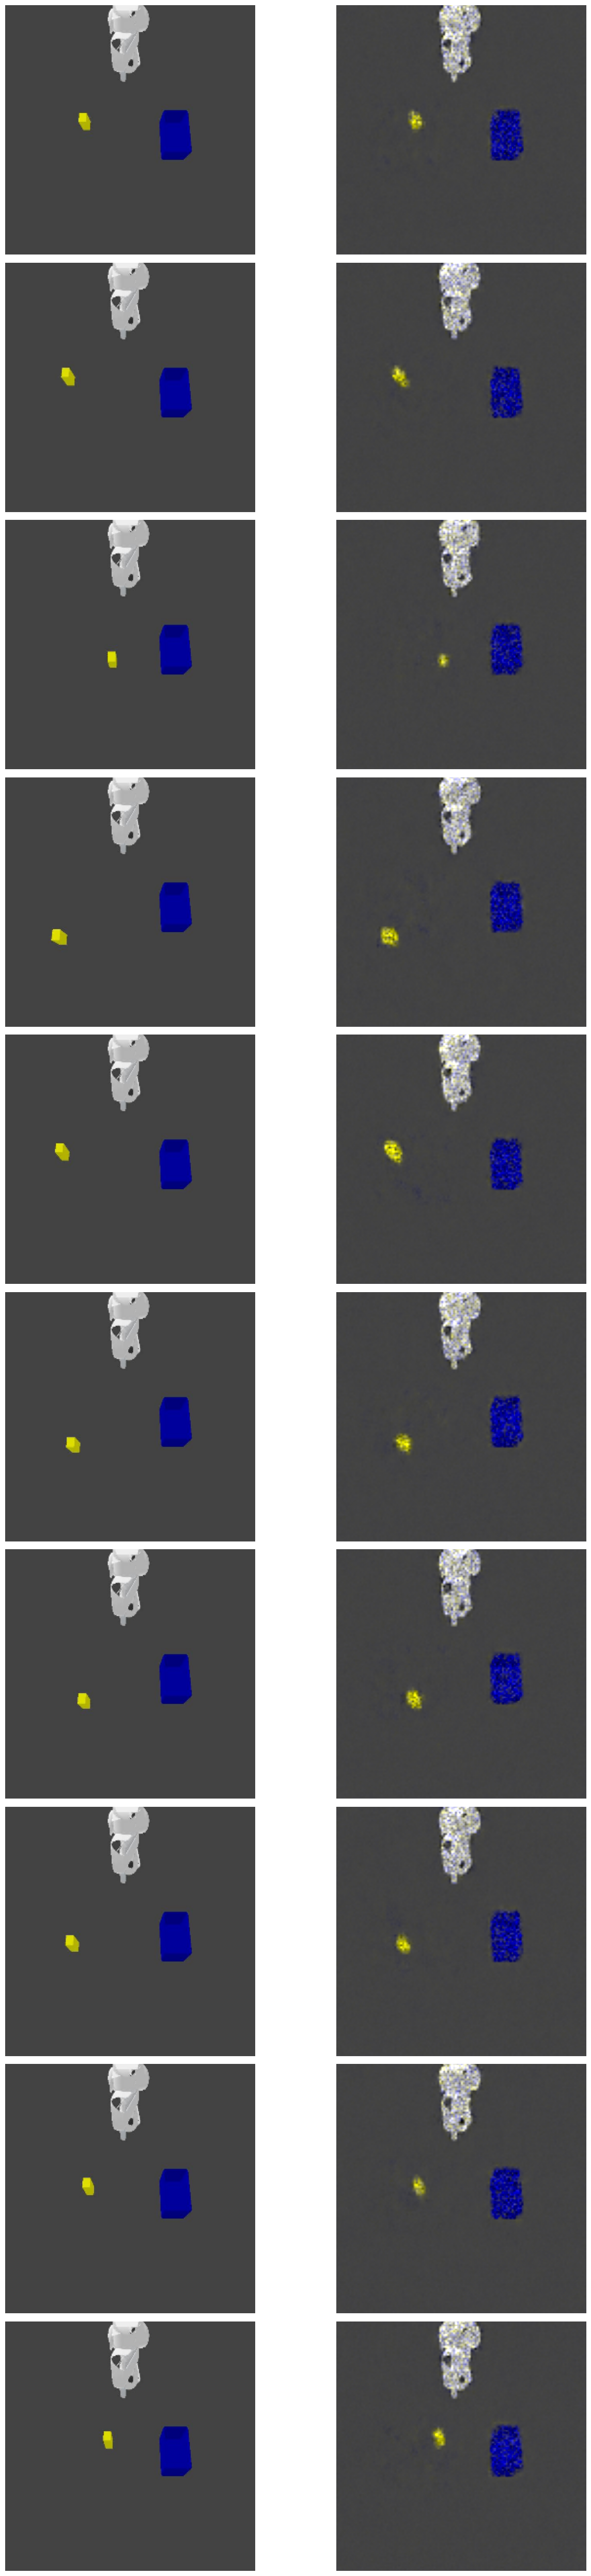

In [28]:
example_count = 10
rand_images = np.array([val_dataset[np.random.randint(0, len(val_dataset))][0] for _ in range(example_count)])
pred_images = encoder.forward_clean(torch.Tensor(rand_images).to(device))

fig, axes = plt.subplots(example_count, 2, figsize=(15, 50))

for i in range(example_count):
    image = np.transpose(rand_images[i], (1, 2, 0))
    axes[i, 0].imshow(image)
    axes[i, 1].imshow(pred_images[i])

    axes[i, 0].axis('off')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [29]:
mlp_model = MLP(LATENT_DIM, y_train.shape[1], hidden_layers=[256, 128]).to(device)
mlp_model, encoder = train_with_encoder(mlp_model, encoder, device, train_loader, val_loader, n_epochs=2000, lr=1e-4)

Epoch 1,	 Train Loss: 0.360739,	 Val Loss: 0.350165
Epoch 2,	 Train Loss: 0.348355,	 Val Loss: 0.342787
Epoch 3,	 Train Loss: 0.339657,	 Val Loss: 0.334916
Epoch 4,	 Train Loss: 0.331081,	 Val Loss: 0.325934
Epoch 5,	 Train Loss: 0.321663,	 Val Loss: 0.314987
Epoch 6,	 Train Loss: 0.312789,	 Val Loss: 0.300922
Epoch 7,	 Train Loss: 0.298953,	 Val Loss: 0.282289
Epoch 8,	 Train Loss: 0.275651,	 Val Loss: 0.257329
Epoch 9,	 Train Loss: 0.250168,	 Val Loss: 0.224224
Epoch 10,	 Train Loss: 0.219984,	 Val Loss: 0.181908
Epoch 11,	 Train Loss: 0.178966,	 Val Loss: 0.131451
Epoch 12,	 Train Loss: 0.125656,	 Val Loss: 0.078722
Epoch 13,	 Train Loss: 0.087637,	 Val Loss: 0.037962
Epoch 14,	 Train Loss: 0.067563,	 Val Loss: 0.026867
Epoch 15,	 Train Loss: 0.071163,	 Val Loss: 0.025923
Epoch 16,	 Train Loss: 0.074057,	 Val Loss: 0.015518
Epoch 17,	 Train Loss: 0.059987,	 Val Loss: 0.008610
Epoch 18,	 Train Loss: 0.045047,	 Val Loss: 0.011655
Epoch 19,	 Train Loss: 0.041754,	 Val Loss: 0.018419
Ep

In [30]:
for i in range(2):
    if i:
        latent_images, _ = encoder.encode(torch.Tensor(X_test).to(device))
        y_pred = mlp_model(latent_images).cpu().detach().numpy()
        errors = y_test - y_pred
    else:
        latent_images, _ = encoder.encode(torch.Tensor(X_train).to(device))
        y_pred = mlp_model(latent_images).cpu().detach().numpy()
        errors = y_train - y_pred
    
    errors = errors[:, :2]
    errors = [np.linalg.norm(e) for e in errors]
    mean_error = sum(errors)/len(errors)
    devs = [abs(e-mean_error) for e in errors]
    dev_error = sum(devs)/len(devs)

    max_error = .015
    total_wins = 0
    for e in errors:
        if e < max_error:
            total_wins += 1

    if i:
        print("Test avg. dist. from desired point (m): ", mean_error)
        print("Test avg. dev. from desired point (m): ", dev_error)
        print(f"Success rate: {(total_wins/len(errors)*100):.2f}%")
    else:
        print("Train avg. dist. from desired point (m): ", mean_error)
        print("Train avg. dev. from desired point (m): ", dev_error)
    print("+--------------------------------------------------------------+")

Train avg. dist. from desired point (m):  0.01302003188419936
Train avg. dev. from desired point (m):  0.007121317143331775
+--------------------------------------------------------------+
Test avg. dist. from desired point (m):  0.01441065593488725
Test avg. dev. from desired point (m):  0.008788252898987827
Success rate: 70.00%
+--------------------------------------------------------------+


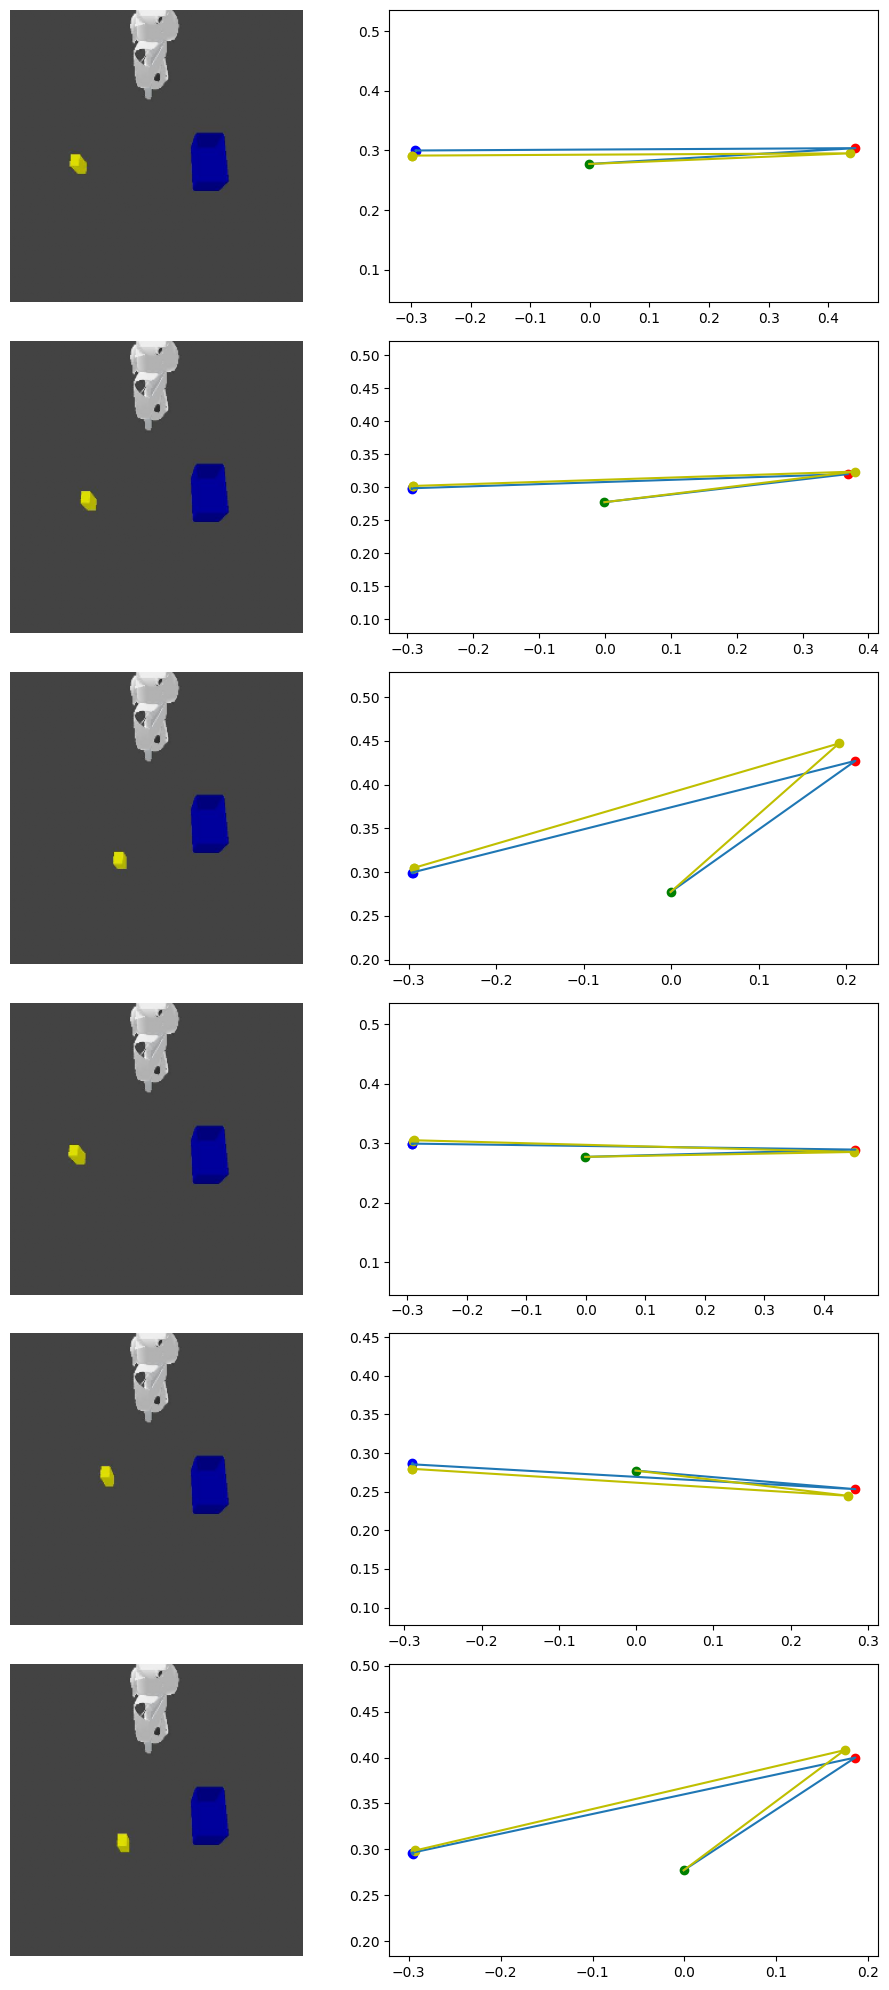

In [31]:
example_count = 6
rand_indices = np.random.choice(list(range(len(X_test))), size=example_count)

imgs = X_test[rand_indices]

target_waypoints = y_test[rand_indices].reshape(6, 3, 3)

latent_images, _ = encoder.encode(torch.Tensor(imgs).to(device))
imgs = np.transpose(imgs, (0, 2, 3, 1))
pred_waypoints = mlp_model(latent_images).cpu().detach().numpy()
pred_waypoints = pred_waypoints.reshape(6, 3, 3)

plot_waypoints_and_initial_image(pred_waypoints, target_waypoints, imgs)

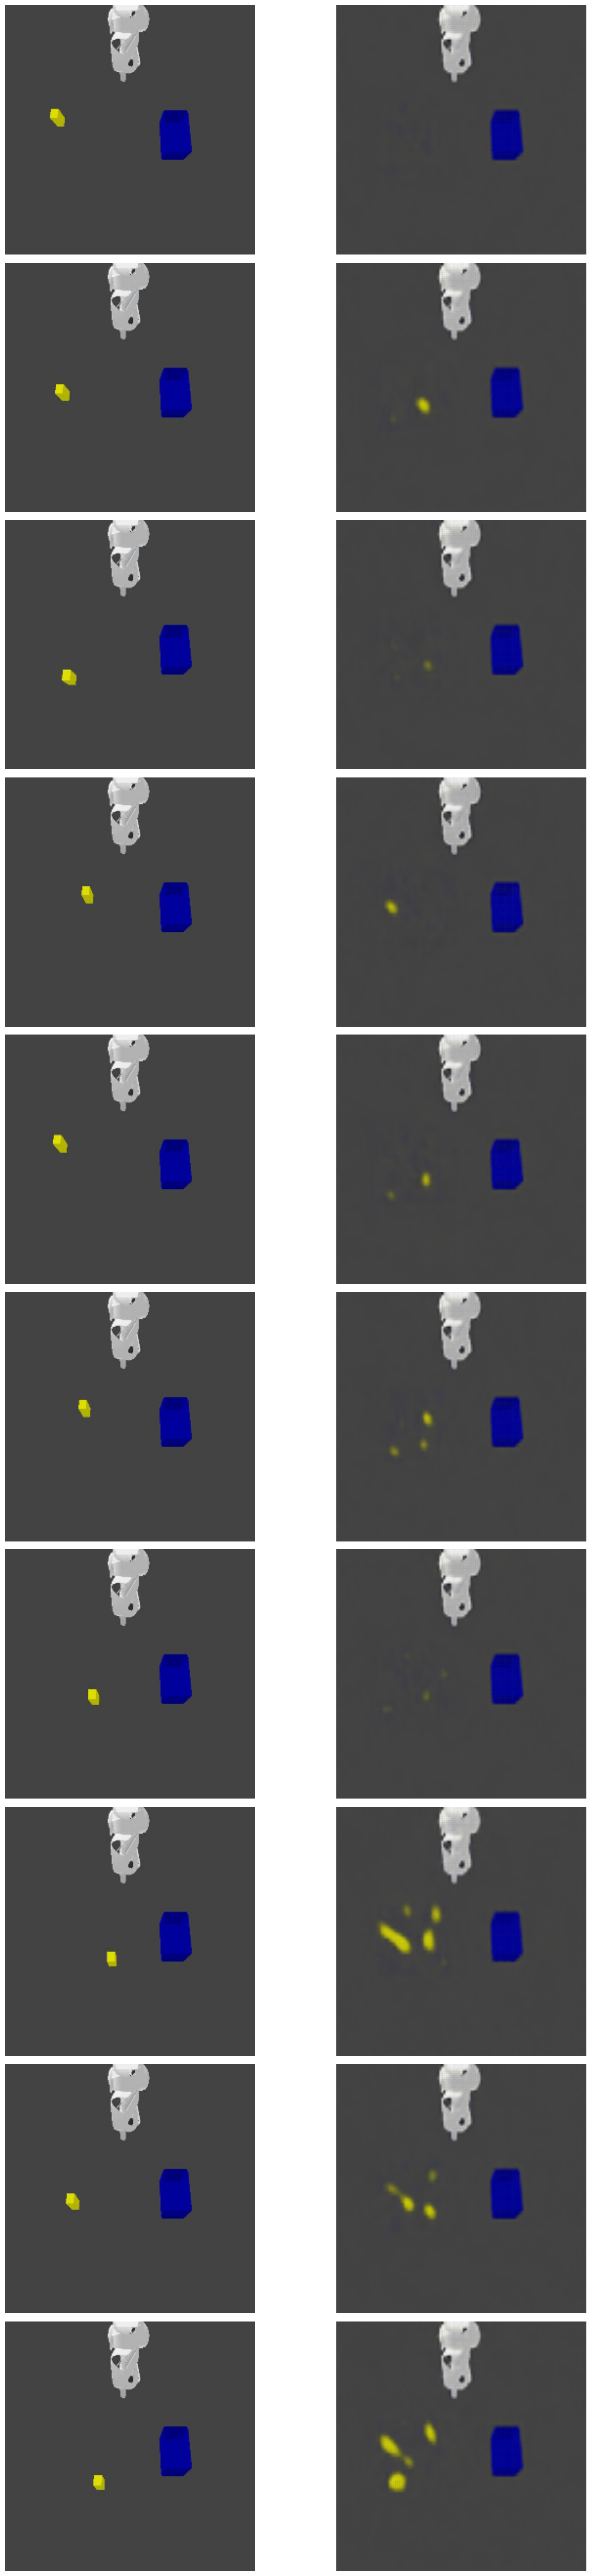

In [32]:
example_count = 10
rand_images = np.array([val_dataset[np.random.randint(0, len(val_dataset))][0] for _ in range(example_count)])
pred_images = encoder.forward_clean(torch.Tensor(rand_images).to(device))

fig, axes = plt.subplots(example_count, 2, figsize=(15, 50))

for i in range(example_count):
    image = np.transpose(rand_images[i], (1, 2, 0))
    axes[i, 0].imshow(image)
    axes[i, 1].imshow(pred_images[i])

    axes[i, 0].axis('off')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()